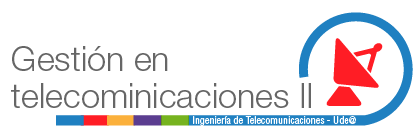

---
# <h1><center>Proyecto Final - Entregable 2</center></h1>

**Gestion de telecomunicaciones II**

*Sebastian Orozco Blandon*

*Maria Lucia Orozco Guerra*

*Carlos Andres Burbano Bedoya*

Facultad de Ingeniería

Universidad de Antioquia


**2023-2**

---

## **Descripción del problema**

El objetivo es crear una solución basada en redes neuronales que estime métricas de rendimiento dadas una "snapshot" de la red. En detalle, esta solución debe predecir el retardo promedio por paquete de extremo a extremo de un origen a un destino, dado: (i) una topología de red, (ii) una configuración de red (enrutamiento, esquema de colas) y (iii) una matriz de tráfico origen-destino.

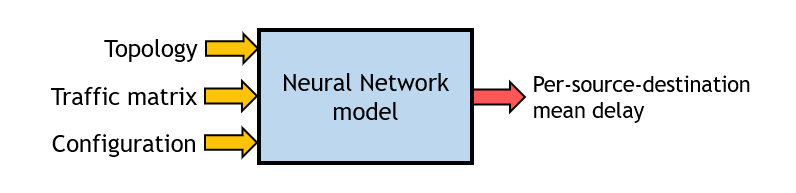

In [ ]:
# Paquetes requeridos para usar RouteNet
!pip install --upgrade pip
!pip install tensorflow
!pip install networkx[default]
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# https://drive.google.com/file/d/1u9EynVoxsAD1hq5hml6_lxp3B_s98hFn/view?usp=sharing

!gdown '1u9EynVoxsAD1hq5hml6_lxp3B_s98hFn'

Downloading...
From: https://drive.google.com/uc?id=1u9EynVoxsAD1hq5hml6_lxp3B_s98hFn
To: /content/routenet.zip
100% 10.9M/10.9M [00:00<00:00, 62.8MB/s]


In [ ]:
!unzip routenet.zip

In [ ]:
# %rm -rf data  # borrar las carpetas

In [ ]:
!cp -r "/content/code" "../"
!cp -r "/content/data" "../"
!cp "/content/code/datanetAPI.py" "/content"

In [ ]:
# Dataset Training de 6,4 Gb
# https://drive.google.com/file/d/18YNCpR_gkOi9SZ4xA2H6u73HxwxiUYlK/view?usp=sharing

!gdown '18YNCpR_gkOi9SZ4xA2H6u73HxwxiUYlK'
!mkdir '/data/real_data/'
!unrar x gnnet_data_set_training.rar
!mv 'train' '/data/real_data/'

In [ ]:
# Dataset Validation de 1,12 Gb
# https://drive.google.com/file/d/1lOQs1BGHZZgU1-JDnIE3UjEfdeQZ78CQ/view?usp=sharing

!gdown '1lOQs1BGHZZgU1-JDnIE3UjEfdeQZ78CQ'
!mkdir '/data/real_data/'
!unrar x gnnet_data_set_validation
!mv 'validation' '/data/real_data/'

In [ ]:
# Dataset de Test de 300 Mb
# https://drive.google.com/file/d/1OcHO3wjOTzNjLOF7RLov6Lhn25XEQL12/view?usp=sharing

!gdown '1OcHO3wjOTzNjLOF7RLov6Lhn25XEQL12'
!mkdir '/data/real_data/'
!unrar x gnnet_data_set_evaluation.rar
!mv 'test' '/data/real_data/'

## Creacion y Entrenamiento de la red neuronal de grafos

In [ ]:
import datanetAPI
import matplotlib.pyplot as plt
import numpy as np
import random

reader = datanetAPI.DatanetAPI("/data/real_data/train",[], [0])  # se lee el dataset de trainning
it = iter(reader)
n = 50000   # numero total de objetos sample a analizar (el dataset tiene mas de 300000) con 50000 tiempo estimado 40 min

# Matrices de caracteristicas para cada topologia
x_nsfnet = np.zeros((n//2, 51))
x_geant2 = np.zeros((n//2, 51))
cont_24 = 0
cont_14 = 0

# supervector de caracteristicas extraidas para 3 enlaces diferentes
caracteristicas = []

for i in range(n):
    sample = next(it)
    m_tr = sample.get_traffic_matrix()   # se extrae la matriz de trafico
    m_per = sample.get_performance_matrix()  # se extrae la matriz de desempeño
    tamaño_red = sample.get_network_size()  # Cantidad de nodos en la red de la muestra
    topology = sample.get_topology_object()  # se extrae el objeto topologia
    gdelay = sample.get_global_delay()   # se extrae el delay global de la red
    gloss = sample.get_global_losses()  # se extraen los paquetes perdidos en la red
    gpacket = sample.get_global_packets()  # se extraen los paquetes generados en toda la red

    for j in range(3):
      if tamaño_red == 24:  # topologia 1 GEANT2
        rango_inferior = 0
        rango_superior = 23
        src = random.randint(rango_inferior, rango_superior//2)
        dst = random.randint(rango_inferior//2, rango_superior)
        if src == dst:
          dst += 1
      elif tamaño_red == 14:  # topologia 2 NSFNET
        rango_inferior = 0
        rango_superior = 13
        src = random.randint(rango_inferior, rango_superior//2)
        dst = random.randint(rango_inferior//2, rango_superior)
        if src == dst:
          dst += 1

      c = []
      bandwidth = m_tr[src,dst]['AggInfo']['AvgBw']  # Ancho de banda promedio en todos los flujos para el enlace de la muestra
      tot_paquets = m_tr[src,dst]['AggInfo']['TotalPktsGen']  # Paquetes totales generados en todos los flujos para el enlace de la muestra
      paquets = m_tr[src,dst]['AggInfo']['PktsGen']  # paquetes generados por unidad de tiempo
      bitrate = m_tr[src,dst]['Flows'][0]['TimeDistParams']['EqLambda']  # tasa promedio de bit
      generacion = m_tr[src,dst]['Flows'][0]['TimeDistParams']['ExpMaxFactor']  # factor exponencial para generar los paquetes
      tamaño_paquete = m_tr[src,dst]['Flows'][0]['SizeDistParams']['AvgPktSize']  # tamaño promedio de los paquetes
      bandwidth_flow = m_tr[src,dst]['Flows'][0]['AvgBw']  # ancho de banda por flujo
      paquets_flow = m_tr[src,dst]['Flows'][0]['PktsGen']  # paquetes generados por flujo
      tos = m_tr[src,dst]['Flows'][0]['ToS']  # tipo de servicio
      delay = m_per[src,dst]['AggInfo']['AvgDelay'] # delay promedio de todos los flujos en el enlace de la muestra
      delay_flow = m_per[src,dst]['Flows'][0]['AvgDelay']  # delay promedio por flujo
      loss_flow = m_per[src,dst]['Flows'][0]['PktsDrop']   # paquetes descartados por flujo
      gjitter = m_per[src,dst]['AggInfo']['Jitter']   # jitter de todos los flujos del enlace de la muestra
      jitter_flow = m_per[src,dst]['Flows'][0]['Jitter']   # jitter por flujo
      qos1 = topology.nodes[src]['levelsQoS']  # calidad de servicio del nodo src
      qos2 = topology.nodes[dst]['levelsQoS']  # calidad de servicio del nodo dst

      c = [tot_paquets, paquets, paquets_flow, bitrate, generacion, tamaño_paquete, bandwidth, bandwidth_flow,
              tos, delay, delay_flow, loss_flow, gjitter, jitter_flow, qos1, qos2]
      caracteristicas += c

    caracteristicas.extend([gpacket, gloss, gdelay])
    if tamaño_red == 24:
      for j in range(51):
        if cont_24 < n//2:
          x_geant2[cont_24][j] = caracteristicas[j]
      cont_24 += 1
    elif tamaño_red == 14:
      for j in range(51):
        if cont_14 < n//2:
          x_nsfnet[cont_14][j] = caracteristicas[j]
      cont_14 +=1
    caracteristicas = []





In [ ]:
# Se crea un dataframe para extraer las caracteristicas mas importantes
carac = ['Paquetes totales enlace 1', 'Paquetes por unidad de tiempo enlace 1', 'Paquetes por flujo enlace 1',
         'Tasa promedio de bit enlace 1', 'Paquetes generados enlace 1', 'Tamaño de paquetes enlace 1', 'Ancho de banda enlace 1',
         'Ancho de banda por flujo enlace 1', 'ToS enlace 1', 'Delay enlace 1', 'Delay por flujo enlace 1', 'Paquetes perdidos enlace 1',
         'Jitter enlace 1', 'Jitter por flujo enlace 1', 'QoS origen enlace 1', 'QoS destino enlace 1', 'Paquetes totales enlace 2',
         'Paquetes por unidad de tiempo enlace 2', 'Paquetes por flujo enlace 2',
         'Tasa promedio de bit enlace 2', 'Paquetes generados enlace 2', 'Tamaño de paquetes enlace 2', 'Ancho de banda enlace 2',
         'Ancho de banda por flujo enlace 2', 'ToS enlace 2', 'Delay enlace 2', 'Delay por flujo enlace 2', 'Paquetes perdidos enlace 2',
         'Jitter enlace 2', 'Jitter por flujo enlace 2', 'QoS origen enlace 2', 'QoS destino enlace 2', 'Paquetes totales enlace 3',
         'Paquetes por unidad de tiempo enlace 3', 'Paquetes por flujo enlace 3',
         'Tasa promedio de bit enlace 3', 'Paquetes generados enlace 3', 'Tamaño de paquetes enlace 3', 'Ancho de banda enlace 3',
         'Ancho de banda por flujo enlace 3', 'ToS enlace 3', 'Delay enlace 3', 'Delay por flujo enlace 3', 'Paquetes perdidos enlace 3',
         'Jitter enlace 3', 'Jitter por flujo enlace 3', 'QoS origen enlace 3', 'QoS destino enlace 3', 'Paquetes generados en red',
         'Paquetes perdidos en red', 'Delay en red']

df_nsfnet = pd.DataFrame(data=x_nsfnet, columns=carac)
df_geant2 = pd.DataFrame(data=x_geant2, columns=carac)

In [ ]:
filas_ceros = df_nsfnet[df_nsfnet.eq(0).all(axis=1)]
df_nsfnet1 = df_nsfnet.drop(index=filas_ceros.index)
df_nsfnet1

In [ ]:
filas_ceros = df_geant2[df_geant2.eq(0).all(axis=1)]
df_geant21 = df_geant2.drop(index=filas_ceros.index)
df_geant21

In [ ]:
df_nsfnet1.to_csv('NSFNET.csv', header=True, index=False)
df_geant21.to_csv('GEANT2.csv', header=True, index=False)

In [ ]:
# GEANT2 train
# https://drive.google.com/file/d/1X0tkkyiDTCm1KbS9WD_4kwRzeHkr-EhO/view?usp=sharing

# NSFNET train
# https://drive.google.com/file/d/1lhmqZNJDTOk4pHa1DYYhlLVQccahLb8c/view?usp=sharing

!gdown '1X0tkkyiDTCm1KbS9WD_4kwRzeHkr-EhO'
!gdown '1lhmqZNJDTOk4pHa1DYYhlLVQccahLb8c'

Downloading...
From: https://drive.google.com/uc?id=1X0tkkyiDTCm1KbS9WD_4kwRzeHkr-EhO
To: /content/GEANT2.csv
100% 9.78M/9.78M [00:00<00:00, 65.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lhmqZNJDTOk4pHa1DYYhlLVQccahLb8c
To: /content/NSFNET.csv
100% 3.08M/3.08M [00:00<00:00, 19.8MB/s]


In [ ]:
df_nsfnet = pd.read_csv('NSFNET.csv')
df_nsfnet

In [ ]:
df_geant2 = pd.read_csv('GEANT2.csv')
df_geant2

In [ ]:
# Juntar los dos dataframes para entrenar la red neuronal

df_train = pd.concat([df_nsfnet, df_geant2], ignore_index=True)
df_train

,Paquetes totales enlace 1,Paquetes por unidad de tiempo enlace 1,Paquetes por flujo enlace 1,Tasa promedio de bit enlace 1,Paquetes generados enlace 1,Tamaño de paquetes enlace 1,Ancho de banda enlace 1,Ancho de banda por flujo enlace 1,ToS enlace 1,Delay enlace 1,...,Delay enlace 3,Delay por flujo enlace 3,Paquetes perdidos enlace 3,Jitter enlace 3,Jitter por flujo enlace 3,QoS origen enlace 3,QoS destino enlace 3,Paquetes generados en red,Paquetes perdidos en red,Delay en red
0,14478.984375,0.308885,0.308885,308.607,10.0,1000.0,306.988,306.988,1.0,0.168455,...,0.233289,0.233289,0.000000,0.023833,0.023833,3.0,3.0,46.8301,0.000000,0.210378
1,38176.985000,0.396644,0.396644,393.490,10.0,1000.0,395.662,395.662,1.0,0.120688,...,0.199452,0.199452,0.000000,0.014425,0.014425,3.0,3.0,109.9830,0.055324,0.402021
2,21845.995600,0.354068,0.354068,359.358,10.0,1000.0,354.952,354.952,2.0,0.181840,...,9.608880,9.608880,0.329951,13.859100,13.859100,3.0,3.0,149.6430,5.511850,1.274070
3,78070.976800,0.863617,0.863617,859.085,10.0,1000.0,862.091,862.091,2.0,3.050980,...,0.063646,0.063646,0.000000,0.002687,0.002687,3.0,3.0,131.5440,1.098560,0.964346
4,14360.979000,0.251947,0.251947,251.349,10.0,1000.0,252.942,252.942,2.0,0.048333,...,0.167082,0.167082,0.000000,0.012293,0.012293,3.0,3.0,82.7869,0.000000,0.275604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32620,20017.973800,0.720071,0.720071,720.700,10.0,1000.0,715.388,715.388,1.0,0.078692,...,2.406670,2.406670,0.007625,2.215870,2.215870,3.0,3.0,556.5310,35.228900,0.902464
32621,5058.991475,0.300683,0.300683,297.325,10.0,1000.0,303.803,303.803,0.0,0.066789,...,0.143268,0.143268,0.000000,0.004579,0.004579,3.0,3.0,536.0650,25.743500,0.838700
32622,11689.968800,0.358588,0.358588,358.241,10.0,1000.0,360.049,360.049,2.0,0.184899,...,1.875350,1.875350,0.728496,0.179272,0.179272,3.0,3.0,486.3270,41.514300,0.534674
32623,25641.990750,1.032910,1.032910,1037.290,10.0,1000.0,1037.760,1037.760,0.0,0.165884,...,0.130457,0.130457,0.000000,0.003834,0.003834,3.0,3.0,389.5070,10.172600,0.462295


In [ ]:
y_train = df_train['Delay en red'].values
x_train = df_train.drop('Delay en red', axis=1).values

In [ ]:
import datanetAPI
import numpy as np
import random

reader = datanetAPI.DatanetAPI("/data/real_data/validation",[], [0])  # se lee el dataset de validation
it = iter(reader)
n = 10000   # numero total de objetos sample a analizar (el dataset tiene 100000) con 10000 tiempo estimado 10 min

# Matrices de caracteristicas para cada topologia
x_gbn = np.zeros((n, 51))

# supervector de caracteristicas extraidas para 3 enlaces diferentes
caracteristicas = []

for i in range(n):
    sample = next(it)
    m_tr = sample.get_traffic_matrix()   # se extrae la matriz de trafico
    m_per = sample.get_performance_matrix()  # se extrae la matriz de desempeño
    tamaño_red = sample.get_network_size()  # Cantidad de nodos en la red de la muestra
    topology = sample.get_topology_object()  # se extrae el objeto topologia
    gdelay = sample.get_global_delay()   # se extrae el delay global de la red
    gloss = sample.get_global_losses()  # se extraen los paquetes perdidos en la red
    gpacket = sample.get_global_packets()  # se extraen los paquetes generados en toda la red

    for j in range(3):
      rango_inferior = 0
      rango_superior = 16
      src = random.randint(rango_inferior, rango_superior//2)
      dst = random.randint(rango_inferior//2, rango_superior)
      if src == dst:
        dst += 1

      c = []
      bandwidth = m_tr[src,dst]['AggInfo']['AvgBw']  # Ancho de banda promedio en todos los flujos para el enlace de la muestra
      tot_paquets = m_tr[src,dst]['AggInfo']['TotalPktsGen']  # Paquetes totales generados en todos los flujos para el enlace de la muestra
      paquets = m_tr[src,dst]['AggInfo']['PktsGen']  # paquetes generados por unidad de tiempo
      bitrate = m_tr[src,dst]['Flows'][0]['TimeDistParams']['EqLambda']  # tasa promedio de bit
      generacion = m_tr[src,dst]['Flows'][0]['TimeDistParams']['ExpMaxFactor']  # factor exponencial para generar los paquetes
      tamaño_paquete = m_tr[src,dst]['Flows'][0]['SizeDistParams']['AvgPktSize']  # tamaño promedio de los paquetes
      bandwidth_flow = m_tr[src,dst]['Flows'][0]['AvgBw']  # ancho de banda por flujo
      paquets_flow = m_tr[src,dst]['Flows'][0]['PktsGen']  # paquetes generados por flujo
      tos = m_tr[src,dst]['Flows'][0]['ToS']  # tipo de servicio
      delay = m_per[src,dst]['AggInfo']['AvgDelay'] # delay promedio de todos los flujos en el enlace de la muestra
      delay_flow = m_per[src,dst]['Flows'][0]['AvgDelay']  # delay promedio por flujo
      loss_flow = m_per[src,dst]['Flows'][0]['PktsDrop']   # paquetes descartados por flujo
      gjitter = m_per[src,dst]['AggInfo']['Jitter']   # jitter de todos los flujos del enlace de la muestra
      jitter_flow = m_per[src,dst]['Flows'][0]['Jitter']   # jitter por flujo
      qos1 = topology.nodes[src]['levelsQoS']  # calidad de servicio del nodo src
      qos2 = topology.nodes[dst]['levelsQoS']  # calidad de servicio del nodo dst

      c = [tot_paquets, paquets, paquets_flow, bitrate, generacion, tamaño_paquete, bandwidth, bandwidth_flow,
              tos, delay, delay_flow, loss_flow, gjitter, jitter_flow, qos1, qos2]
      caracteristicas += c

    caracteristicas.extend([gpacket, gloss, gdelay])

    for j in range(51):
        x_gbn[i][j] = caracteristicas[j]

    caracteristicas = []




In [ ]:
carac = ['Paquetes totales enlace 1', 'Paquetes por unidad de tiempo enlace 1', 'Paquetes por flujo enlace 1',
         'Tasa promedio de bit enlace 1', 'Paquetes generados enlace 1', 'Tamaño de paquetes enlace 1', 'Ancho de banda enlace 1',
         'Ancho de banda por flujo enlace 1', 'ToS enlace 1', 'Delay enlace 1', 'Delay por flujo enlace 1', 'Paquetes perdidos enlace 1',
         'Jitter enlace 1', 'Jitter por flujo enlace 1', 'QoS origen enlace 1', 'QoS destino enlace 1', 'Paquetes totales enlace 2',
         'Paquetes por unidad de tiempo enlace 2', 'Paquetes por flujo enlace 2',
         'Tasa promedio de bit enlace 2', 'Paquetes generados enlace 2', 'Tamaño de paquetes enlace 2', 'Ancho de banda enlace 2',
         'Ancho de banda por flujo enlace 2', 'ToS enlace 2', 'Delay enlace 2', 'Delay por flujo enlace 2', 'Paquetes perdidos enlace 2',
         'Jitter enlace 2', 'Jitter por flujo enlace 2', 'QoS origen enlace 2', 'QoS destino enlace 2', 'Paquetes totales enlace 3',
         'Paquetes por unidad de tiempo enlace 3', 'Paquetes por flujo enlace 3',
         'Tasa promedio de bit enlace 3', 'Paquetes generados enlace 3', 'Tamaño de paquetes enlace 3', 'Ancho de banda enlace 3',
         'Ancho de banda por flujo enlace 3', 'ToS enlace 3', 'Delay enlace 3', 'Delay por flujo enlace 3', 'Paquetes perdidos enlace 3',
         'Jitter enlace 3', 'Jitter por flujo enlace 3', 'QoS origen enlace 3', 'QoS destino enlace 3', 'Paquetes generados en red',
         'Paquetes perdidos en red', 'Delay en red']

df_gbn = pd.DataFrame(data=x_gbn, columns=carac)

In [ ]:
df_gbn.to_csv('GBN.csv', header=True, index=False)

In [ ]:
# GBN validation
# https://drive.google.com/file/d/14AtRXU1xLxJb-i0n6n-yP1SF4N6f9ASR/view?usp=sharing

!gdown '14AtRXU1xLxJb-i0n6n-yP1SF4N6f9ASR'

Downloading...
From: https://drive.google.com/uc?id=14AtRXU1xLxJb-i0n6n-yP1SF4N6f9ASR
To: /content/GBN.csv
100% 3.95M/3.95M [00:00<00:00, 24.9MB/s]


In [ ]:
df_gbn = pd.read_csv('GBN.csv')
df_gbn

,Paquetes totales enlace 1,Paquetes por unidad de tiempo enlace 1,Paquetes por flujo enlace 1,Tasa promedio de bit enlace 1,Paquetes generados enlace 1,Tamaño de paquetes enlace 1,Ancho de banda enlace 1,Ancho de banda por flujo enlace 1,ToS enlace 1,Delay enlace 1,...,Delay enlace 3,Delay por flujo enlace 3,Paquetes perdidos enlace 3,Jitter enlace 3,Jitter por flujo enlace 3,QoS origen enlace 3,QoS destino enlace 3,Paquetes generados en red,Paquetes perdidos en red,Delay en red
0,13666.935150,0.137841,0.137841,137.850,10.0,1000.0,137.778,137.778,2.0,0.152349,...,0.065951,0.065951,0.000000,0.001613,0.001613,3.0,3.0,163.899,0.498154,0.409908
1,30818.913750,1.212150,1.212150,1214.080,10.0,1000.0,1212.120,1212.120,0.0,0.266402,...,2.430970,2.430970,0.264857,0.761152,0.761152,3.0,3.0,286.818,37.210200,1.808090
2,58597.778750,1.424870,1.424870,1428.600,10.0,1000.0,1418.300,1418.300,2.0,0.220090,...,3.728510,3.728510,0.151586,0.515932,0.515932,3.0,3.0,222.627,15.417500,1.091480
3,40403.082500,1.034650,1.034650,1030.380,10.0,1000.0,1036.420,1036.420,1.0,0.032894,...,0.156008,0.156008,0.000000,0.007847,0.007847,3.0,3.0,244.968,21.207400,1.221710
4,9036.970250,0.224521,0.224521,223.502,10.0,1000.0,227.043,227.043,2.0,4.364890,...,0.148884,0.148884,0.000000,0.007974,0.007974,3.0,3.0,232.214,13.347900,1.032120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,36855.930000,0.376850,0.376850,377.858,10.0,1000.0,377.623,377.623,1.0,0.620732,...,0.409997,0.409997,0.000000,0.061361,0.061361,3.0,3.0,160.319,1.049810,0.652681
9996,74586.039000,1.178760,1.178760,1179.420,10.0,1000.0,1184.220,1184.220,2.0,15.051400,...,0.627245,0.627245,0.000000,0.060850,0.060850,3.0,3.0,198.344,16.964100,1.523330
9997,118092.868950,0.784931,0.784931,785.146,10.0,1000.0,785.076,785.076,2.0,0.220202,...,0.280284,0.280284,0.000000,0.025414,0.025414,3.0,3.0,122.949,0.429950,0.387027
9998,58602.907025,0.623933,0.623933,624.231,10.0,1000.0,624.567,624.567,1.0,0.101998,...,0.307262,0.307262,0.000000,0.036176,0.036176,3.0,3.0,158.472,9.170940,0.608166


In [ ]:
y_test = df_gbn['Delay en red'].values
x_test = df_gbn.drop('Delay en red', axis=1).values

In [ ]:
fila_train = -10000   # reduccion de las muestras por facilidad de computo y revision de predicciones
fila_test = -4000
x_train_red = df_train.drop('Delay en red', axis=1).iloc[:fila_train].values
y_train_red = df_train['Delay en red'].iloc[:fila_train].values
x_test_red = df_gbn.drop('Delay en red', axis=1).iloc[:fila_test].values
y_test_red = df_gbn['Delay en red'].iloc[:fila_test].values

Se decide crear una NN de una neorona simple para implementar regresion, que es el metodo necesario para predecir los valores del Delay que es lo que el problema original pretende hacer en base a las caracteristicas que se escogieron para contruir la matriz **X** que posee caracteristicas de las topologias NSFNET y GEANT2, y asi entrenar el modelo y probarlo posteriormente con la topologia GBN y ver que tan preciso o no es el modelo.

### **NN de neurona simple**

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import StandardScaler

# Cambio de formato para la NN
y_train = y_train_red.astype(np.float32)
x_train = x_train_red.astype(np.float32)
x_test = x_test_red.astype(np.float32)
y_test = y_test_red.astype(np.float32)
input_dim = x_train_red.shape[1]

# Escalado de los datos
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
sc_X = StandardScaler()
sc_y = StandardScaler()
x_train = sc_X.fit_transform(x_train)
x_test = sc_X.fit_transform(x_test)
y_train = sc_y.fit_transform(y_train)
y_test = sc_y.fit_transform(y_test)

# Inicializar variables y optimizador fuera de la función
W = tf.Variable(tf.random.normal((input_dim, 1), mean=0.0, stddev=1.0), dtype=tf.float32, name="weight")
b = tf.Variable(tf.zeros((1,), dtype=tf.float32), name="bias")
optimizer = tf.optimizers.Adam(learning_rate=0.03)  # Usar el optimizador Adam

# Definir el modelo y la función de entrenamiento con regularización L2 (una neurona)
@tf.function
def model(x):
    return tf.add(tf.matmul(x, W), b, name="output")

@tf.function
def train_step(x, y, lmbda=0.01):  # Parámetro lambda para la regularización
    with tf.GradientTape() as tape:
        predictions = model(x)
        loss = tf.reduce_mean(tf.square(predictions - y))
        regularizer = tf.nn.l2_loss(W)  # Regularización L2
        loss += lmbda * regularizer  # Añadir término de regularización al loss
    gradients = tape.gradient(loss, [W, b])
    optimizer.apply_gradients(zip(gradients, [W, b]))
    return loss

# Entrenamiento de la red neuronal con regularización
for epoch in range(2000):
    current_loss = train_step(x_train, y_train)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {current_loss}")


Epoch 0, Loss: 11.13027286529541
Epoch 100, Loss: 0.45690956711769104
Epoch 200, Loss: 0.42981934547424316
Epoch 300, Loss: 0.4137534201145172
Epoch 400, Loss: 0.40041694045066833
Epoch 500, Loss: 0.39047354459762573
Epoch 600, Loss: 0.38364890217781067
Epoch 700, Loss: 0.37926745414733887
Epoch 800, Loss: 0.37660375237464905
Epoch 900, Loss: 0.3750540316104889
Epoch 1000, Loss: 0.3741830587387085
Epoch 1100, Loss: 0.37370648980140686
Epoch 1200, Loss: 0.3734510838985443
Epoch 1300, Loss: 0.3733164370059967
Epoch 1400, Loss: 0.3732464611530304
Epoch 1500, Loss: 0.3732104003429413
Epoch 1600, Loss: 0.3731973171234131
Epoch 1700, Loss: 0.3731822371482849
Epoch 1800, Loss: 0.373177170753479
Epoch 1900, Loss: 0.37317439913749695


### Implementacion del modelo de NN

In [ ]:
# Realizar predicciones para nuevas matrices de características con la topolgia GBN
y_pred = model(x_test)

y_test_original = sc_y.inverse_transform(y_test)
pred_original = sc_y.inverse_transform(y_pred)

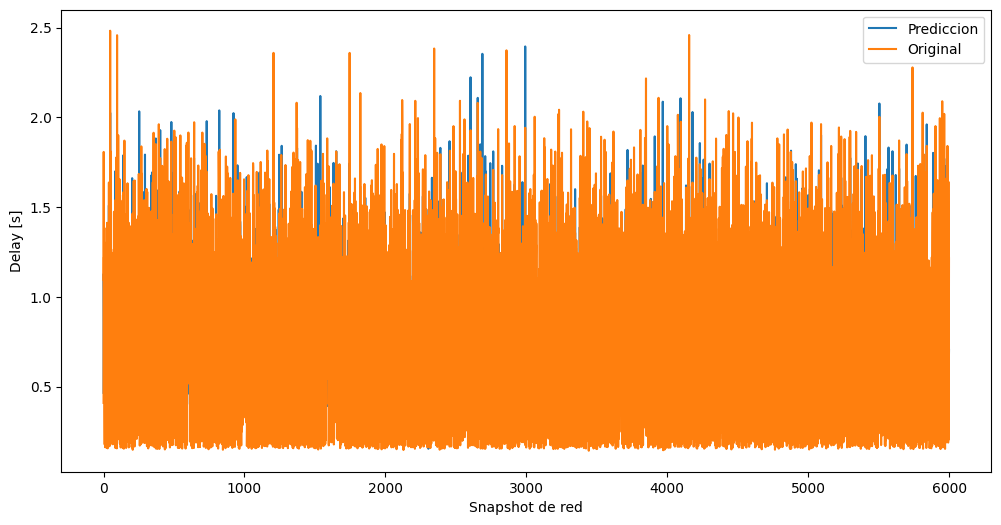

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(pred_original,label ='Prediccion')
plt.plot(y_test_original,label ='Original')
plt.xlabel('Snapshot de red')
plt.ylabel('Delay [s]')
plt.legend()

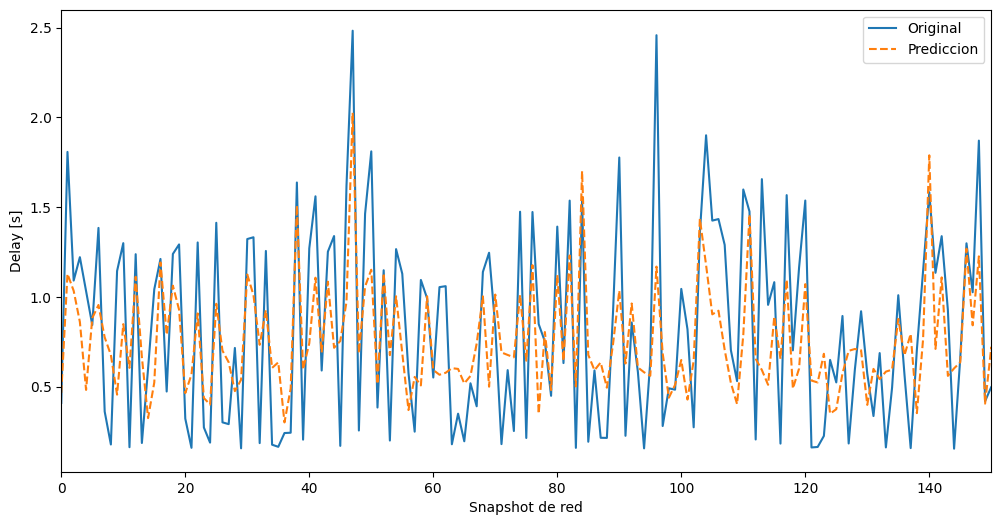

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test_original,label ='Original')
plt.plot(pred_original, '--',label ='Prediccion')
plt.xlabel('Snapshot de red')
plt.ylabel('Delay [s]')
plt.xlim(0,150)
plt.legend()

In [ ]:
from sklearn import metrics

print('MAPE', metrics.mean_absolute_percentage_error(y_test_original, pred_original)*100,'%')
print('MAE:', metrics.mean_absolute_error(y_test_original, pred_original))
print('MSE:', metrics.mean_squared_error(y_test_original, pred_original))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test_original, pred_original)))
print('R2 score:', metrics.r2_score(y_test_original, pred_original))

MAPE 81.47776461258344 %
MAE: 0.3136728070110065
MSE: 0.1369905780464755
RMSE: 0.3701223825256661
R2 score: 0.4769573086581541


Analisando el comportamiento del modelo para el caso donde se tomaban la mayoria de muestras (filas de la matriz **X**) se observaban valores menores de R2 y mayores de MAE, es decir, el modelo era menos preciso tomando muchas muestras, lo que se puede deducir es que el modelo caia en el sobre entrenamiento y esto provocaba que los resultados al crecer los datos de entrada fuera menos preciso (aumentara el error). Con esta cantidad de datos elegida se obtienen mejores resultados.

### **NN con capas ocultas**

In [ ]:
# NN con capas ocultas
input_dim = x_train.shape[1]
hidden_units = 2

# Cambio de formato para la NN
y_train = y_train_red.astype(np.float32)
x_train = x_train_red.astype(np.float32)
x_test = x_test_red.astype(np.float32)
y_test = y_test_red.astype(np.float32)

# Escalado de los datos
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
sc_X = StandardScaler()
sc_y = StandardScaler()
x_train = sc_X.fit_transform(x_train)
x_test = sc_X.fit_transform(x_test)
y_train = sc_y.fit_transform(y_train)
y_test = sc_y.fit_transform(y_test)

# Inicializar variables y optimizador fuera de la función
W1 = tf.Variable(tf.random.normal((input_dim, hidden_units), mean=0.0, stddev=1.0), dtype=tf.float32, name="weight1")
b1 = tf.Variable(tf.zeros((hidden_units,), dtype=tf.float32), name="bias1")
W2 = tf.Variable(tf.random.normal((hidden_units, 1), mean=0.0, stddev=1.0), dtype=tf.float32, name="weight2")
b2 = tf.Variable(tf.zeros((1,), dtype=tf.float32), name="bias2")
optimizer = tf.optimizers.Adam(learning_rate=0.05)

# Definir el modelo y la función de entrenamiento
@tf.function
def model_hidden(x):
    hidden_layer = tf.add(tf.matmul(x, W1), b1)
    hidden_layer = tf.nn.relu(hidden_layer)  # Función de activación ReLU para la capa oculta
    output_layer = tf.add(tf.matmul(hidden_layer, W2), b2)
    return output_layer

@tf.function
def train_step(x, y, lmbda=0.01):
    with tf.GradientTape() as tape:
        predictions = model_hidden(x)
        loss = tf.reduce_mean(tf.square(predictions - y))
        regularizer = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2)
        loss += lmbda * regularizer
    gradients = tape.gradient(loss, [W1, b1, W2, b2])
    optimizer.apply_gradients(zip(gradients, [W1, b1, W2, b2]))
    return loss

# Entrenamiento de la red neuronal con regularización
for epoch in range(2000):
    current_loss = train_step(x_train, y_train)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {current_loss}")



Epoch 0, Loss: 13.133943557739258
Epoch 100, Loss: 0.4944026470184326
Epoch 200, Loss: 0.2906714975833893
Epoch 300, Loss: 0.23024623095989227
Epoch 400, Loss: 0.20064325630664825
Epoch 500, Loss: 0.17770980298519135
Epoch 600, Loss: 0.14913122355937958
Epoch 700, Loss: 0.14124879240989685
Epoch 800, Loss: 0.1425856649875641
Epoch 900, Loss: 0.13761615753173828
Epoch 1000, Loss: 0.14093688130378723
Epoch 1100, Loss: 0.1370236724615097
Epoch 1200, Loss: 0.13795699179172516
Epoch 1300, Loss: 0.13628725707530975
Epoch 1400, Loss: 0.1362353414297104
Epoch 1500, Loss: 0.1366792470216751
Epoch 1600, Loss: 0.1429736614227295
Epoch 1700, Loss: 0.1362602859735489
Epoch 1800, Loss: 0.14173078536987305
Epoch 1900, Loss: 0.13661035895347595


### Implementacion de NN con capas ocultas

In [ ]:
# Realizar predicciones para nuevas matrices de características con la topolgia GBN
y_pred = model_hidden(x_test)

y_test_original = sc_y.inverse_transform(y_test)
pred_original = sc_y.inverse_transform(y_pred)

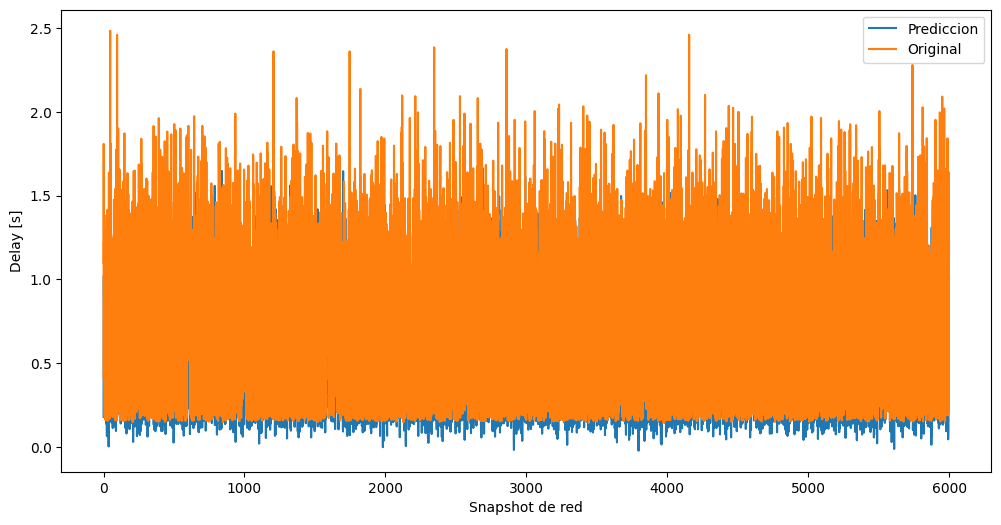

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(pred_original,label ='Prediccion')
plt.plot(y_test_original,label ='Original')
plt.xlabel('Snapshot de red')
plt.ylabel('Delay [s]')
plt.legend()

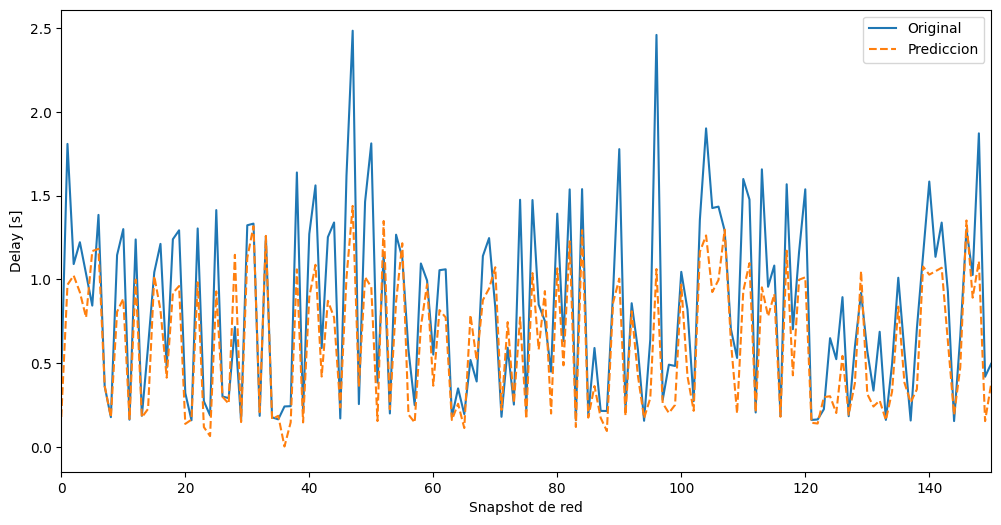

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test_original,label ='Original')
plt.plot(pred_original, '--',label ='Prediccion')
plt.xlabel('Snapshot de red')
plt.ylabel('Delay [s]')
plt.xlim(0,150)
plt.legend()

In [ ]:
print('MAPE', metrics.mean_absolute_percentage_error(y_test_original, pred_original)*100,'%')
print('MAE:', metrics.mean_absolute_error(y_test_original, pred_original))
print('MSE:', metrics.mean_squared_error(y_test_original, pred_original))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test_original, pred_original)))
print('R2 score:', metrics.r2_score(y_test_original, pred_original))

MAPE 26.7695960128358 %
MAE: 0.20470301276304023
MSE: 0.08169919388735936
RMSE: 0.28583070844008235
R2 score: 0.6880649248971971


Aqui podemos observar que el modelo con 2 capas ocultas ofrece un mejor resultado que el modelo de una neurona simple, tanto en el calculo del R2 y del MAE, manteniendo los mismo datos para el entrenamiento, el factor de aprendizaje y el modo de implementacion del optimizador Adam. Lo que cambia en la construccion del modelo es agregar dos conjuntos de pesos diferentes por las capas ocultas que se agregan, las cuales utilizan la funcion de activacion ReLu. Hay que tomar en cuenta que como los pesos **W** se definen de forma aleatoria es posible que si se hacen varios experimentos la precision de la prediccion se puede ver afectada tanto positiva como negativamente. Para entregar resultados bien documentados es necesario hacer pruebas iterativas para ver en que punto el modelo se comporta de la mejor manera.

## Otras predicciones con el dataset restante

En este dataset se entregan datos de una topologia distinta a las 3 vistas en estre proyecto (NSFNET, GEANT2, GBN)

In [ ]:
import datanetAPI
import random
reader = datanetAPI.DatanetAPI("/data/real_data/test",[], [0])  # se lee el dataset de test (topologia diferente)
it = iter(reader)
n = 10000   # numero total de objetos sample para el dataset de test = 47400

# Matrices de caracteristicas para cada topologia
x_dif = np.zeros((n, 51))

# supervector de caracteristicas extraidas para 3 enlaces diferentes
caracteristicas = []

for i in range(n):
    sample = next(it)
    m_tr = sample.get_traffic_matrix()   # se extrae la matriz de trafico
    m_per = sample.get_performance_matrix()  # se extrae la matriz de desempeño
    tamaño_red = sample.get_network_size()  # Cantidad de nodos en la red de la muestra
    topology = sample.get_topology_object()  # se extrae el objeto topologia
    gdelay = sample.get_global_delay()   # se extrae el delay global de la red
    gloss = sample.get_global_losses()  # se extraen los paquetes perdidos en la red
    gpacket = sample.get_global_packets()  # se extraen los paquetes generados en toda la red

    for j in range(3):
      rango_inferior = 0
      rango_superior = tamaño_red - 1
      src = random.randint(rango_inferior, rango_superior//2)
      dst = random.randint(rango_inferior//2, rango_superior)
      if src == dst:
        dst += 1

      c = []
      bandwidth = m_tr[src,dst]['AggInfo']['AvgBw']  # Ancho de banda promedio en todos los flujos para el enlace de la muestra
      tot_paquets = m_tr[src,dst]['AggInfo']['TotalPktsGen']  # Paquetes totales generados en todos los flujos para el enlace de la muestra
      paquets = m_tr[src,dst]['AggInfo']['PktsGen']  # paquetes generados por unidad de tiempo
      bitrate = m_tr[src,dst]['Flows'][0]['TimeDistParams']['EqLambda']  # tasa promedio de bit
      generacion = m_tr[src,dst]['Flows'][0]['TimeDistParams']['ExpMaxFactor']  # factor exponencial para generar los paquetes
      tamaño_paquete = m_tr[src,dst]['Flows'][0]['SizeDistParams']['AvgPktSize']  # tamaño promedio de los paquetes
      bandwidth_flow = m_tr[src,dst]['Flows'][0]['AvgBw']  # ancho de banda por flujo
      paquets_flow = m_tr[src,dst]['Flows'][0]['PktsGen']  # paquetes generados por flujo
      tos = m_tr[src,dst]['Flows'][0]['ToS']  # tipo de servicio
      delay = m_per[src,dst]['AggInfo']['AvgDelay'] # delay promedio de todos los flujos en el enlace de la muestra
      delay_flow = m_per[src,dst]['Flows'][0]['AvgDelay']  # delay promedio por flujo
      loss_flow = m_per[src,dst]['Flows'][0]['PktsDrop']   # paquetes descartados por flujo
      gjitter = m_per[src,dst]['AggInfo']['Jitter']   # jitter de todos los flujos del enlace de la muestra
      jitter_flow = m_per[src,dst]['Flows'][0]['Jitter']   # jitter por flujo
      qos1 = topology.nodes[src]['levelsQoS']  # calidad de servicio del nodo src
      qos2 = topology.nodes[dst]['levelsQoS']  # calidad de servicio del nodo dst

      c = [tot_paquets, paquets, paquets_flow, bitrate, generacion, tamaño_paquete, bandwidth, bandwidth_flow,
              tos, delay, delay_flow, loss_flow, gjitter, jitter_flow, qos1, qos2]
      caracteristicas += c

    caracteristicas.extend([gpacket, gloss, gdelay])

    for j in range(51):
        x_dif[i][j] = caracteristicas[j]

    caracteristicas = []


In [ ]:
carac = ['Paquetes totales enlace 1', 'Paquetes por unidad de tiempo enlace 1', 'Paquetes por flujo enlace 1',
         'Tasa promedio de bit enlace 1', 'Paquetes generados enlace 1', 'Tamaño de paquetes enlace 1', 'Ancho de banda enlace 1',
         'Ancho de banda por flujo enlace 1', 'ToS enlace 1', 'Delay enlace 1', 'Delay por flujo enlace 1', 'Paquetes perdidos enlace 1',
         'Jitter enlace 1', 'Jitter por flujo enlace 1', 'QoS origen enlace 1', 'QoS destino enlace 1', 'Paquetes totales enlace 2',
         'Paquetes por unidad de tiempo enlace 2', 'Paquetes por flujo enlace 2',
         'Tasa promedio de bit enlace 2', 'Paquetes generados enlace 2', 'Tamaño de paquetes enlace 2', 'Ancho de banda enlace 2',
         'Ancho de banda por flujo enlace 2', 'ToS enlace 2', 'Delay enlace 2', 'Delay por flujo enlace 2', 'Paquetes perdidos enlace 2',
         'Jitter enlace 2', 'Jitter por flujo enlace 2', 'QoS origen enlace 2', 'QoS destino enlace 2', 'Paquetes totales enlace 3',
         'Paquetes por unidad de tiempo enlace 3', 'Paquetes por flujo enlace 3',
         'Tasa promedio de bit enlace 3', 'Paquetes generados enlace 3', 'Tamaño de paquetes enlace 3', 'Ancho de banda enlace 3',
         'Ancho de banda por flujo enlace 3', 'ToS enlace 3', 'Delay enlace 3', 'Delay por flujo enlace 3', 'Paquetes perdidos enlace 3',
         'Jitter enlace 3', 'Jitter por flujo enlace 3', 'QoS origen enlace 3', 'QoS destino enlace 3', 'Paquetes generados en red',
         'Paquetes perdidos en red', 'Delay en red']

df_new = pd.DataFrame(data=x_dif, columns=carac)

In [ ]:
df_new.to_csv('TEST.csv', header=True, index=False)

In [ ]:
# Topologia de testeo
# https://drive.google.com/file/d/10u66nwR0KE-lDCySW3ltsgU5gpvUEov2/view?usp=sharing

!gdown '10u66nwR0KE-lDCySW3ltsgU5gpvUEov2'

Downloading...
From: https://drive.google.com/uc?id=10u66nwR0KE-lDCySW3ltsgU5gpvUEov2
To: /content/TEST.csv
100% 3.50M/3.50M [00:00<00:00, 22.1MB/s]


In [ ]:
df_new = pd.read_csv('TEST.csv')
df_new

,Paquetes totales enlace 1,Paquetes por unidad de tiempo enlace 1,Paquetes por flujo enlace 1,Tasa promedio de bit enlace 1,Paquetes generados enlace 1,Tamaño de paquetes enlace 1,Ancho de banda enlace 1,Ancho de banda por flujo enlace 1,ToS enlace 1,Delay enlace 1,...,Delay enlace 3,Delay por flujo enlace 3,Paquetes perdidos enlace 3,Jitter enlace 3,Jitter por flujo enlace 3,QoS origen enlace 3,QoS destino enlace 3,Paquetes generados en red,Paquetes perdidos en red,Delay en red
0,29075.989500,0.848934,0.848934,861.577,10.0,1000.0,846.563,846.563,2.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,3.0,3.0,337.0240,20.172600,0.838334
1,9717.972000,0.234168,0.234168,231.116,10.0,1000.0,235.079,235.079,1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,3.0,3.0,91.2377,0.000000,0.137738
2,7449.989800,0.446776,0.446776,451.703,10.0,1000.0,444.677,444.677,1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,3.0,3.0,369.3060,34.957000,0.877230
3,45573.954750,0.832401,0.832401,836.800,10.0,1000.0,834.421,834.421,2.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,3.0,3.0,188.8450,0.000018,0.189436
4,25778.970000,1.636760,1.636760,1637.030,10.0,1000.0,1642.760,1642.760,1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,3.0,3.0,331.6690,14.801000,0.642069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,45507.971475,0.667517,0.667517,669.082,10.0,1000.0,668.893,668.893,2.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,3.0,3.0,205.9690,3.894930,0.491051
9996,75972.760500,1.348230,1.348230,1346.700,10.0,1000.0,1354.010,1354.010,2.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,3.0,3.0,336.3930,20.736000,1.372680
9997,12336.968650,0.272039,0.272039,272.527,10.0,1000.0,268.566,268.566,1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,3.0,3.0,233.0110,2.319870,0.466745
9998,17623.981500,0.876815,0.876815,871.089,10.0,1000.0,880.507,880.507,2.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,3.0,3.0,333.8280,32.134800,0.925398


In [ ]:
fila_test = -4000
x_test2 = df_new.drop('Delay en red', axis=1).iloc[:fila_test].values
y_test2 = df_new['Delay en red'].iloc[:fila_test].values

### **Test con la NN simple**

In [ ]:
x_test2 = x_test2.astype(np.float32)
x_test2 = sc_X.fit_transform(x_test2)

# predecir los delay de esta nueva topologia con el modelo ya entrenado previamente
y_pred2 = model(x_test2)
pred2_original = sc_y.inverse_transform(y_pred2)

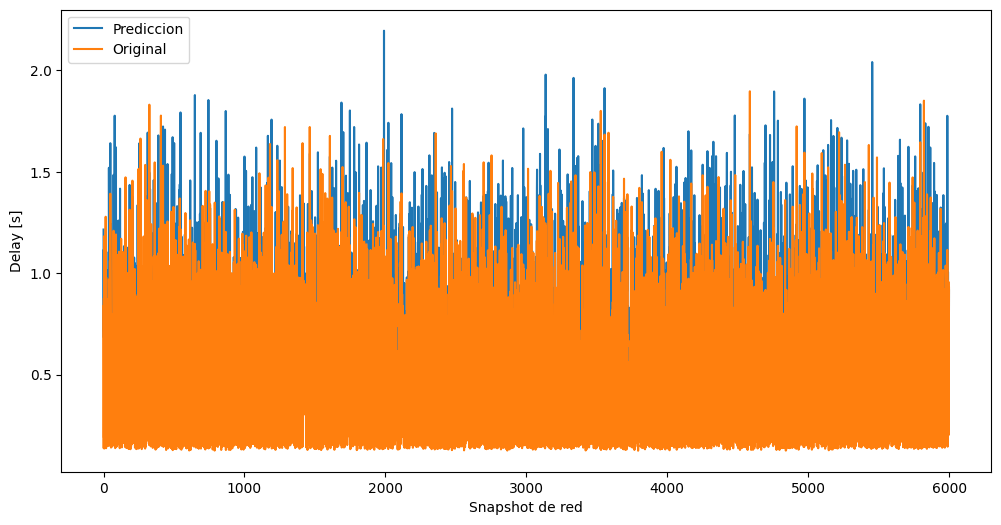

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(pred2_original,label ='Prediccion')
plt.plot(y_test2,label ='Original')
plt.xlabel('Snapshot de red')
plt.ylabel('Delay [s]')
plt.legend()

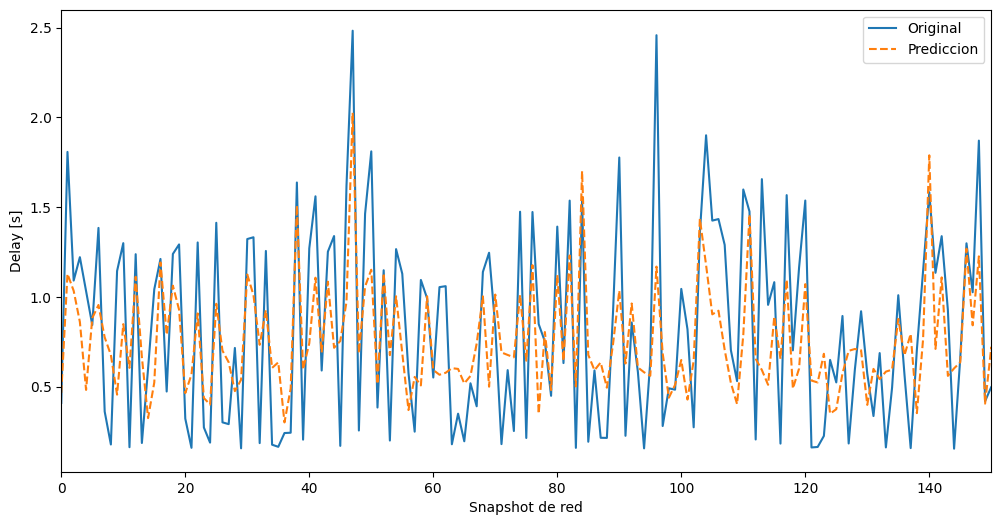

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test_original,label ='Original')
plt.plot(pred_original, '--',label ='Prediccion')
plt.xlabel('Snapshot de red')
plt.ylabel('Delay [s]')
plt.xlim(0,150)
plt.legend()

In [ ]:
print('MAPE', metrics.mean_absolute_percentage_error(y_test2, pred2_original)*100,'%')
print('MAE:', metrics.mean_absolute_error(y_test2, pred2_original))
print('MSE:', metrics.mean_squared_error(y_test2, pred2_original))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test2, pred2_original)))
print('R2 score:', metrics.r2_score(y_test2, pred2_original))

MAPE 142.39985961235968 %
MAE: 0.32789065904506765
MSE: 0.14531644971022234
RMSE: 0.38120394765823495
R2 score: -0.10191132474568643


### **Test con la NN con capas ocultas**

In [ ]:
x_test2 = x_test2.astype(np.float32)
x_test2 = sc_X.fit_transform(x_test2)

# predecir los delay de esta nueva topologia con el modelo ya entrenado previamente
y_pred2 = model_hidden(x_test2)
pred2_original = sc_y.inverse_transform(y_pred2)

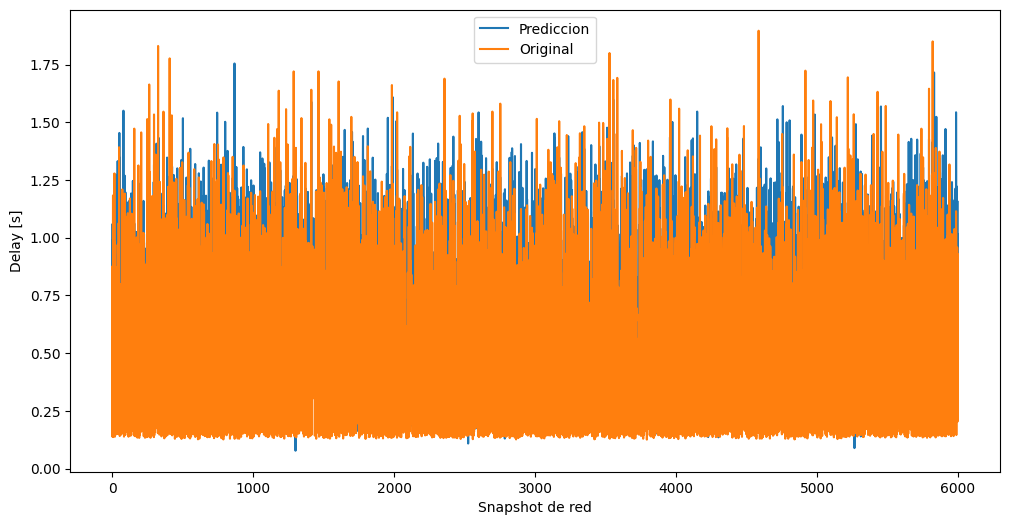

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(pred2_original,label ='Prediccion')
plt.plot(y_test2,label ='Original')
plt.xlabel('Snapshot de red')
plt.ylabel('Delay [s]')
plt.legend()

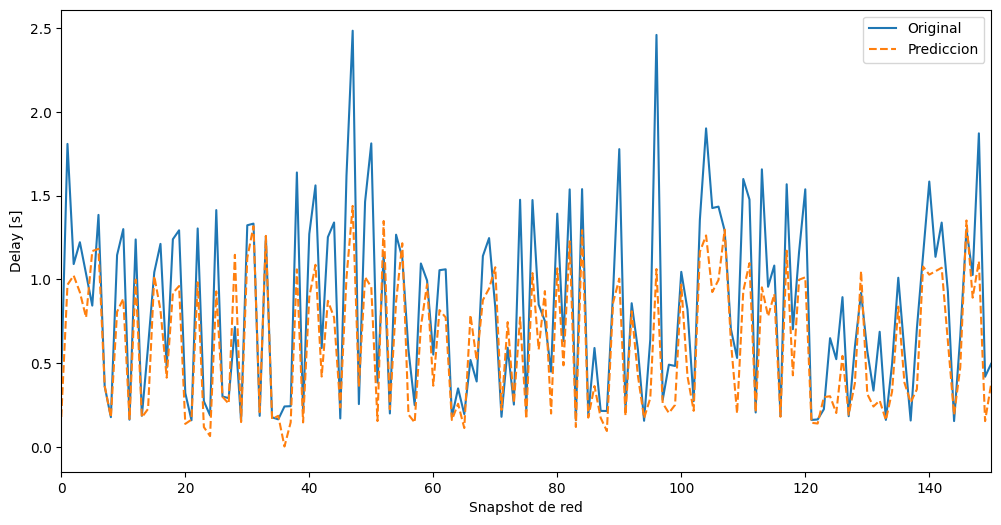

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test_original,label ='Original')
plt.plot(pred_original, '--',label ='Prediccion')
plt.xlabel('Snapshot de red')
plt.ylabel('Delay [s]')
plt.xlim(0,150)
plt.legend()

In [ ]:
print('MAPE', metrics.mean_absolute_percentage_error(y_test2, pred2_original)*100,'%')
print('MAE:', metrics.mean_absolute_error(y_test2, pred2_original))
print('MSE:', metrics.mean_squared_error(y_test2, pred2_original))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test2, pred2_original)))
print('R2 score:', metrics.r2_score(y_test2, pred2_original))

MAPE 53.69793222866668 %
MAE: 0.17392222405678823
MSE: 0.04569379865281976
RMSE: 0.21376107843295458
R2 score: 0.6535112555626292


Se observa que tambien hay un buen desempeño utilizando la NN con capas ocultas en base a las metricas calculadas de esta nueva topologia de la cual no se tiene mucho conocimiento, habría que procesar su dataset para revisar mas caracteristicas y por qué alguno valores son negativos como se observó en el dataframe extraido de este conjunto de datos.

## Resumen de los MAPE calculados

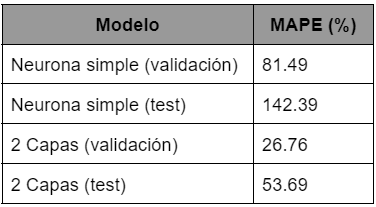

### **MAPE Que se obtuvieron en el desafio usando GNN**

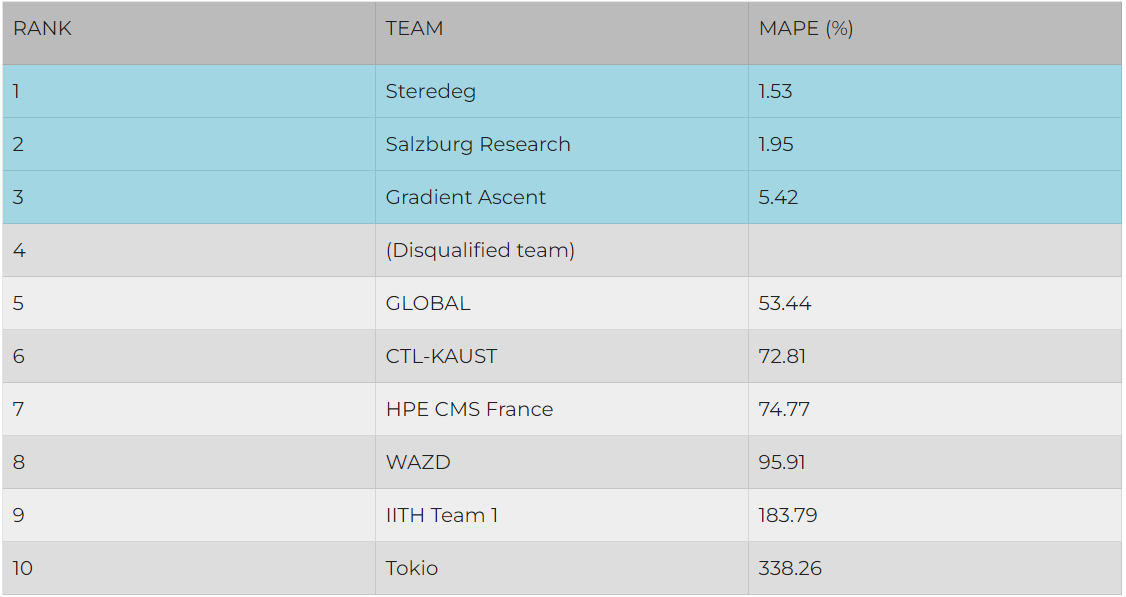

Se puede concluir en base a estos datos que el uso de una NN mas sencilla de construir e implementar que una GNN entrega resultados convenientes en base a la participación de este reto, ya que para el caso del dataset de test que es con el que se hizo la evaluación en el desafio se hubiera quedado en el puesto número 8 utilizando la red neuronal simple, y se hubiera quedado en el puesto número 5 (estando muy parejos con el cuarto lugar con una diferencia del 0.25%) utilizando la red neuronal con 2 capas ocultas; siendo muchos los participantes del reto es un buen resultado, se puede incluso revisar la optimización del modelo agregando o quitando variables de la matriz de características o incluyendo parámetros adicionales a la red neuronal o aumentando las epocas de entrenamiento. El caso con la GNN esque involucra el grafo o matriz de adyacencia la cual indica la relación entre los nodos existentes, y esto puede ser complejo de implementar en el caso de esta base de datos, al poseer multiples características propias de cada nodo. De igual manera no garantiza ser siempre mejor que los modelos mas sencillos, debido a que la predicción depende de muchas cosas las cuales no podemos controlar o deducir en primera instancia como para dar un veredicto de cuál es mejor en todos los casos. Aquí nos basamos en las métricas que la ITU entregó de los 10 mejores resultados para su desafío usando Routenet como GNN.

## Campos de aplicación de esta técnica de IA
**Optimización de la topología de red:** Las redes neuronales pueden ayudar a analizar la topología de una red de comunicaciones y optimizarla para mejorar la eficiencia y reducir la latencia. Esto podría ser útil en redes de telecomunicaciones, Internet de las cosas (IoT) y otras infraestructuras de red.

**Detección de anomalías:** Las redes neuronales pueden ser entrenadas para identificar patrones anormales en el tráfico de red como anomalías puntuales, anomalías contextuales o anomalías colectivas. Esto podría ayudar a detectar intrusiones, ataques cibernéticos u otros comportamientos no deseados en una red.



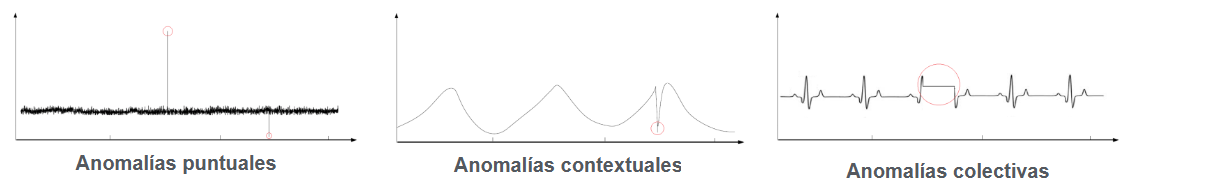


**Gestión de la calidad de servicio (QoS):** Las redes neuronales pueden contribuir a priorizar el tráfico y los recursos para garantizar el rendimiento de una aplicación o servicio específico. También permite a las empresas priorizar diferentes aplicaciones, flujos de datos y usuarios para garantizar el nivel óptimo de rendimiento en todas sus redes.

**Diseño de redes:** Durante la fase de planificación y diseño  de la red, las redes neuronales pueden ayudar a predecir la demanda de trafico y asi optimizar la ubicación de los nodos y planificar de manera efectiva una posible expansión de la red.



**Gestión de la congestión:** Las redes neuronales pueden contribuir a identificar áreas de congestión en una red y asi proponer estrategias para contrarrestar y prevenir estos problemas, como la redistribución de recursos.

**Eficiencia energética**: En las telecomunicaciones las redes neuronales pueden ayudar a optimizar el uso de energía al analizar el tráfico y ajustar en tiempo real las configuraciónes de red para minimizar el consumo de energía sin afectar el rendimiento.

## Bibliografia

https://www.ibm.com/docs/es/spss-modeler/saas?topic=networks-neural-model

https://www.ciiia.mx/noticiasciiia/redes-neuronales-de-grafos-qu-son

https://www.tlm.unavarra.es/~daniel/docencia/arss/arss06_07/slides/5-Retardos.pdf

https://pedrobq.gitbooks.io/fundamentos-de-redes/content/retardos_su_origen_y_medidas_para_su_correccion/retardo_de_cola.html

https://bnn.upc.edu/challenge/gnnet2020/

https://www.research-bl.com/es/2019/10/10/automatic-detection-of-anomalies-in-systems-behaviors/